In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ Predicted Lung Condition: Fibrosis
📊 Confidence Score: 27.43%


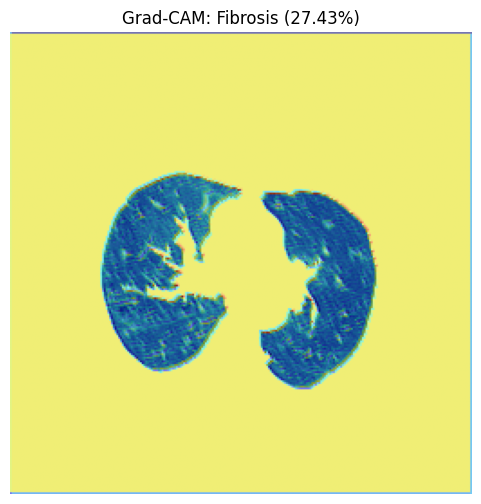

True

In [ ]:
# @title Unet Model With Grad CAM

!pip install numpy==1.26.4 scipy==1.12.0 scikit-image==0.22.0 pydicom opencv-python matplotlib torch torchvision pyradiomics SimpleITK tensorflow tensorflow-keras efficientnet

# Import necessary libraries
import numpy as np
import pydicom
import cv2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------- Set Device --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------- Dummy UNet --------------------
class DummyUNet(nn.Module):
    def __init__(self):
        super(DummyUNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

# -------------------- Dummy Classifier --------------------
class DummyClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(DummyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        self.features = F.relu(self.conv1(x))  # Store for Grad-CAM
        x = self.pool(self.features).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return x

# -------------------- Grad-CAM Class --------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        self.hook_handles.append(self.target_layer.register_forward_hook(self._forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(self._backward_hook))

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[0, class_idx].backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# -------------------- Load Models --------------------
unet_model = DummyUNet().to(device)
classifier = DummyClassifier(num_classes=5).to(device)

# (Optional) Load Trained Weights
# unet_model.load_state_dict(torch.load("unet.pth"))
# classifier.load_state_dict(torch.load("lung_classifier.pth"))

classes = ['Normal', 'GGO', 'Consolidation', 'Fibrosis', 'Crazy Paving']

# -------------------- Load and Preprocess DICOM --------------------
dicom_path = r"/content/drive/MyDrive/ALLlungimg/Normal/P253/Series4/0768.dcm"
dicom_image = pydicom.dcmread(dicom_path)
image_array = dicom_image.pixel_array.astype(np.float32)
intercept = dicom_image.RescaleIntercept
slope = dicom_image.RescaleSlope
hu_image = image_array * slope + intercept
hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# -------------------- Lung Mask Generation --------------------
lung_mask = (hu_resized > -950) & (hu_resized < -400)
lung_mask_filled = binary_fill_holes(lung_mask)
lung_mask_cleaned = morphology.remove_small_objects(lung_mask_filled, min_size=1500)
labeled_mask = label(lung_mask_cleaned)
regions = regionprops(labeled_mask)
regions = sorted(regions, key=lambda r: r.area, reverse=True)[:2]
final_lung_mask = np.zeros_like(hu_resized, dtype=np.uint8)
for region in regions:
    for coord in region.coords:
        final_lung_mask[coord[0], coord[1]] = 1

# -------------------- Extract Lung Region --------------------
lungs_only = hu_resized * final_lung_mask
lungs_display = (lungs_only - np.min(lungs_only)) / (np.max(lungs_only) - np.min(lungs_only))

# -------------------- Prepare Tensor --------------------
input_tensor = torch.tensor(lungs_display).unsqueeze(0).unsqueeze(0).float().to(device)

# -------------------- Run UNet + Classifier --------------------
with torch.no_grad():
    lung_segment = unet_model(input_tensor)
    prediction_logits = classifier(input_tensor)
    probs = torch.softmax(prediction_logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_class].item()

print(f"✅ Predicted Lung Condition: {classes[pred_class]}")
print(f"📊 Confidence Score: {confidence * 100:.2f}%")

# -------------------- Grad-CAM --------------------
# The target layer for Grad-CAM should be the last convolutional layer before global average pooling or flatten
# In this DummyClassifier, 'conv1' is the only conv layer. Adjust this if your actual classifier is different.
grad_cam = GradCAM(classifier, classifier.conv1)
cam_output = grad_cam.generate(input_tensor, class_idx=pred_class)
grad_cam.remove_hooks()

# -------------------- Visualize --------------------
seg_image = lung_segment.squeeze().cpu().numpy()
seg_overlay = (seg_image - np.min(seg_image)) / (np.max(seg_image) - np.min(seg_image))

plt.figure(figsize=(6, 6))
plt.title(f"Grad-CAM: {classes[pred_class]} ({confidence*100:.2f}%)")
plt.imshow(lungs_display, cmap='gray')
# Resize CAM output to match the image size for overlay
cam_resized = cv2.resize(cam_output, (lungs_display.shape[1], lungs_display.shape[0]))
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

# -------------------- Save Heatmap --------------------
cv2.imwrite(f"gradcam_{classes[pred_class]}.png", (cam_resized * 255).astype(np.uint8))

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radi


─── Keras VGG-16 + Radiomics ───
Prediction: Consolidation
Confidence: 100.00%


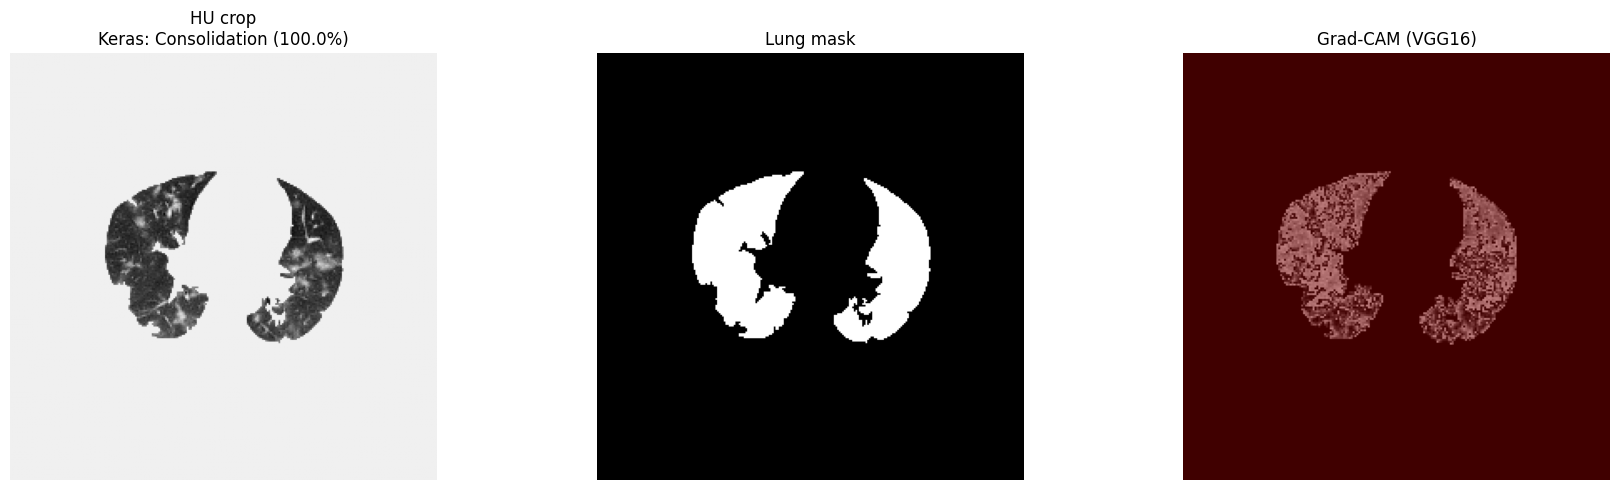

In [ ]:
# @title VGG-16 With Grad CAM With 100% {"display-mode":"both"}
# ============================================================
# 0. Imports
# ============================================================
!pip install segmentation_models_pytorch
import os, numpy as np, cv2, pydicom, matplotlib.pyplot as plt, warnings
from skimage import morphology
from skimage.measure import label as sk_label, regionprops
# Corrected the import path for binary_fill_holes
from scipy.ndimage import binary_fill_holes
import SimpleITK as sitk
from radiomics import featureextractor

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models  import Model

import torch, torch.nn as nn, torch.nn.functional as F
import segmentation_models_pytorch as smp
from torchvision import models

warnings.filterwarnings("ignore", category=UserWarning)

# ============================================================
# 1. Paths & devices
# ============================================================
DICOM_PATH   = r"/content/drive/MyDrive/150img5/Severe/0477.dcm"
UNET_WEIGHTS = "unet.pth"
CLS_WEIGHTS  = "classifier.pth"

TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TF_DEVICE    = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"

# ============================================================
# 2. Load DICOM → HU → resize 256×256
# ============================================================
ds          = pydicom.dcmread(DICOM_PATH)
hu_image    = ds.pixel_array.astype(np.float32) * ds.RescaleSlope + ds.RescaleIntercept
hu_resized  = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# ============================================================
# 3. Robust BOTH-lung mask (keep exactly 2 lung-shaped blobs)
# ============================================================
mask_all  = (hu_resized > -950) & (hu_resized < -400)
mask_all  = binary_fill_holes(mask_all)
mask_all  = morphology.remove_small_objects(mask_all, min_size=1000)

lbl       = sk_label(mask_all)
regions   = sorted(regionprops(lbl), key=lambda r: r.area, reverse=True)

lung_regs = []
for r in regions:
    h, w   = r.bbox[2]-r.bbox[0], r.bbox[3]-r.bbox[1]
    aspect = h / (w + 1e-6)
    if 0.5 < aspect < 3 and 2_000 < r.area < 120_000:
        lung_regs.append(r)
    if len(lung_regs) == 2:
        break

both_mask = np.zeros_like(hu_resized, dtype=np.uint8)
for reg in lung_regs:
    both_mask[tuple(reg.coords.T)] = 1

# ============================================================
# 4. Crop + normalise
# ============================================================
both_crop  = hu_resized * both_mask
both_norm  = (both_crop - both_crop.min()) / (both_crop.max()-both_crop.min()+1e-6)

# ============================================================
# 5-A.  Radiomics vector (PyRadiomics)
# ============================================================
sitk.WriteImage(sitk.GetImageFromArray(both_crop.astype(np.float32)), "tmp_img.nii")
sitk.WriteImage(sitk.GetImageFromArray(both_mask.astype(np.uint8)),   "tmp_mask.nii")
rad_feats = featureextractor.RadiomicsFeatureExtractor().execute("tmp_img.nii","tmp_mask.nii")
rad_vec   = np.array([v for v in rad_feats.values() if isinstance(v,(int,float))])

# ============================================================
# 5-B.  Keras | VGG-16 + radiomics hybrid
# ============================================================
with tf.device(TF_DEVICE):
    img_224 = cv2.resize(both_crop, (224,224))
    img_224 = np.repeat(img_224[...,None], 3, axis=-1) / 255.0
    img_bat = img_224[np.newaxis,...]

    inp_img = Input(shape=(224,224,3))
    inp_rad = Input(shape=(len(rad_vec),))
    base    = VGG16(weights="imagenet", include_top=False, input_tensor=inp_img)
    x       = GlobalAveragePooling2D()(base.output)
    x       = Concatenate()([x, inp_rad])
    x       = Dense(128, activation="relu")(x)
    out     = Dense(5, activation="softmax")(x)
    keras_model = Model([inp_img, inp_rad], out)

    probs_tf = keras_model.predict([img_bat, rad_vec[np.newaxis,...]], verbose=0)
    label_tf = ['GGO','Consolidation','CrazyPaving','Fibrosis','Normal'][probs_tf.argmax()]
    conf_tf  = probs_tf.max()

    # Grad-CAM
    def compute_gradcam(model, image, rad_vec, class_idx=None):
        last_conv_layer = model.get_layer("block5_conv3")
        grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model([image, rad_vec])
            if class_idx is None:
                class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, conv_outputs)[0]
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

        heatmap = np.maximum(heatmap, 0)
        # Added epsilon for stable division
        heatmap /= np.max(heatmap) + 1e-8
        # Remove .numpy() here as heatmap is already a numpy array
        return heatmap

    heatmap = compute_gradcam(keras_model, img_bat, rad_vec[np.newaxis,...], class_idx=probs_tf.argmax())
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    overlay = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted((img_224 * 255).astype(np.uint8), 0.5, overlay, 0.5, 0)
    cv2.imwrite("gradcam_keras_vgg16.png", overlay_img)

# ============================================================
# 6. Console summary
# ============================================================
print("\n─── Keras VGG-16 + Radiomics ───")
print(f"Prediction: {label_tf}")
print(f"Confidence: {conf_tf * 100:.2f}%")

# ============================================================
# 7. Visualisation
# ============================================================
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(both_crop, cmap="gray")
plt.title(f"HU crop\nKeras: {label_tf} ({conf_tf*100:.1f}%)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(both_mask, cmap="gray")
plt.title("Lung mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_img)
plt.title("Grad-CAM (VGG16)")
plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Predicted Labels: ['GGO', 'Crazy Paving']
📊 Probabilities: {'GGO': 0.77, 'Consolidation': 0.32, 'Crazy Paving': 0.63, 'Fibrosis': 0.48, 'Normal': 0.42}


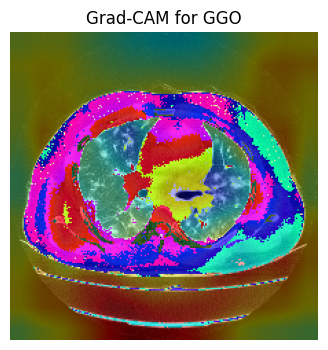

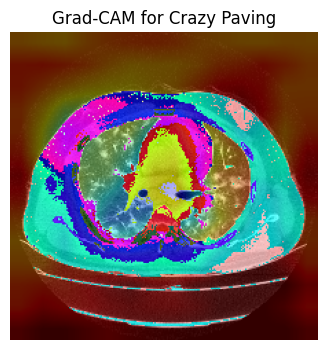

In [ ]:
# @title Grad CAM With Multi Labels With Visualizations {"display-mode":"both"}
# -------------------- Imports --------------------
import os
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

# -------------------- Config --------------------
DICOM_PATH = "/content/drive/MyDrive/150img5/Severe/0477.dcm"
LABELS = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']  # Multi-labels
NUM_CLASSES = len(LABELS)

# -------------------- Load and Preprocess CT --------------------
def load_dicom_and_preprocess(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array.astype(np.float32)
    image = image * ds.RescaleSlope + ds.RescaleIntercept
    image = np.clip(image, -1000, 400)  # Windowing for lung
    image = cv2.resize(image, (224, 224))
    image = np.repeat(image[..., None], 3, axis=-1)
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)
    return image[np.newaxis, ...]

img_input = load_dicom_and_preprocess(DICOM_PATH)

# -------------------- VGG16 Model for Multi-label --------------------
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Multi-label output
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy())

# model.load_weights("vgg16_multilabel.h5")  # Optional if pretrained

# -------------------- Prediction --------------------
probs = model.predict(img_input)[0]
predicted_classes = [LABELS[i] for i, p in enumerate(probs) if p > 0.5]
print(f"✅ Predicted Labels: {predicted_classes}")
print(f"📊 Probabilities: {dict(zip(LABELS, probs.round(2)))}")

# -------------------- Grad-CAM --------------------
def compute_grad_cam(model, img_array, class_idx):
    grad_model = Model([model.inputs], [model.get_layer("block5_conv3").output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / tf.reduce_max(cam)
    return cam.numpy()

# -------------------- Color Maps per Class --------------------
label_colormaps = {
    "GGO": cv2.COLORMAP_JET,
    "Consolidation": cv2.COLORMAP_HOT,
    "Crazy Paving": cv2.COLORMAP_OCEAN,
    "Fibrosis": cv2.COLORMAP_SUMMER,
    "Normal": cv2.COLORMAP_BONE,
}

# -------------------- Visualize Grad-CAM --------------------
for i, label in enumerate(LABELS):
    if probs[i] > 0.5:
        cam = compute_grad_cam(model, img_input, i)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img_input[0] * 255
        plt.figure(figsize=(4, 4))
        plt.title(f"Grad-CAM for {label}")
        plt.imshow(superimposed_img.astype(np.uint8))
        plt.axis('off')
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Predicted Labels: ['GGO', 'Crazy Paving', 'Fibrosis', 'Normal']
📊 Probabilities: {'GGO': 0.65, 'Consolidation': 0.45, 'Crazy Paving': 0.5, 'Fibrosis': 0.53, 'Normal': 0.71}


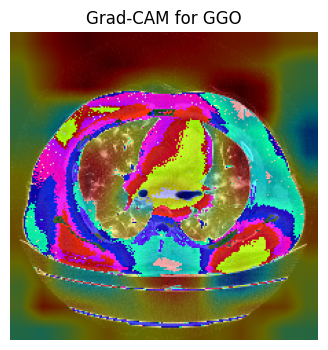

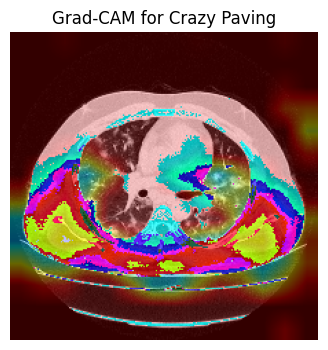

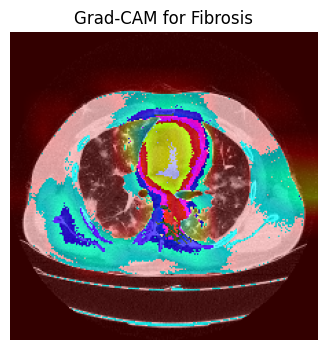

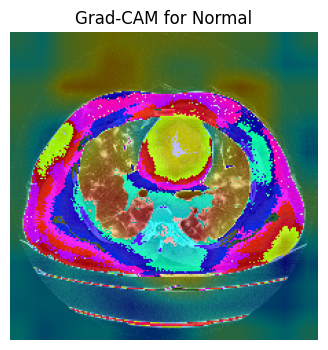

In [ ]:
# @title Grad CAM Labels Separate Image
# -------------------- Imports --------------------
import os
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf

# -------------------- Config --------------------
DICOM_PATH = "/content/drive/MyDrive/150img5/Severe/0477.dcm"
LABELS = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']  # Multi-labels
NUM_CLASSES = len(LABELS)

# -------------------- Load and Preprocess CT --------------------
def load_dicom_and_preprocess(path):
    ds = pydicom.dcmread(path)
    image = ds.pixel_array.astype(np.float32)
    image = image * ds.RescaleSlope + ds.RescaleIntercept
    image = np.clip(image, -1000, 400)  # Windowing for lung
    image = cv2.resize(image, (224, 224))
    image = np.repeat(image[..., None], 3, axis=-1)
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)
    return image[np.newaxis, ...]

img_input = load_dicom_and_preprocess(DICOM_PATH)

# -------------------- VGG16 Model for Multi-label --------------------
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Multi-label output
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss=BinaryCrossentropy())

# model.load_weights("vgg16_multilabel.h5")  # Optional if pretrained

# -------------------- Prediction --------------------
probs = model.predict(img_input)[0]
predicted_classes = [LABELS[i] for i, p in enumerate(probs) if p > 0.5]
print(f"✅ Predicted Labels: {predicted_classes}")
print(f"📊 Probabilities: {dict(zip(LABELS, probs.round(2)))}")

# -------------------- Grad-CAM --------------------
def compute_grad_cam(model, img_array, class_idx):
    grad_model = Model([model.inputs], [model.get_layer("block5_conv3").output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / tf.reduce_max(cam)
    return cam.numpy()

# -------------------- Color Maps per Class --------------------
label_colormaps = {
    "GGO": cv2.COLORMAP_JET,
    "Consolidation": cv2.COLORMAP_HOT,
    "Crazy Paving": cv2.COLORMAP_OCEAN,
    "Fibrosis": cv2.COLORMAP_SUMMER,
    "Normal": cv2.COLORMAP_BONE,
}

# -------------------- Visualize Grad-CAM --------------------
for i, label in enumerate(LABELS):
    if probs[i] > 0.5:
        cam = compute_grad_cam(model, img_input, i)
        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img_input[0] * 255
        plt.figure(figsize=(4, 4))
        plt.title(f"Grad-CAM for {label}")
        plt.imshow(superimposed_img.astype(np.uint8))
        plt.axis('off')
        plt.show()
